# Rossmann Store Sales Prediction
# By Mohamed Eltayeb

# Import libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix


from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)

In [56]:
conda install -c conda-forge lightgbm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.2



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [57]:
#The Evaluation Metric
def RMSPE(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

In [58]:
#Plot the LGBM Features Importances
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

# Read the training and testing data


In [59]:
train_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/train.csv",dtype={'StateHoliday': object})
test_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/test.csv")
store_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/store.csv")

In [60]:
train_df = pd.merge(train_df, store_df, how = 'left', on = 'Store')
test_df = pd.merge(test_df, store_df, how = 'left', on = 'Store')

# Convert the Tabular Data to Time Series Data

In [61]:
ID = test_df['Id']
test_df.drop('Id',inplace=True,axis=1)

train_df.sort_values(["Store","Date"], ignore_index=True, inplace=True)
test_df.sort_values(["Store","Date"], ignore_index=True, inplace=True)

for dataset in (train_df,test_df):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['Day'] = dataset.Date.dt.day
    dataset['Month'] = dataset.Date.dt.month
    dataset['Year'] = dataset.Date.dt.year
    dataset['DayOfYear'] = dataset.Date.dt.dayofyear
    dataset['WeekOfYear'] = dataset.Date.dt.weekofyear
    dataset.set_index('Date', inplace=True)

# Exploratory data analysis

# Features:

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [62]:
train_df.shape

(1017209, 22)

In [63]:
test_df.shape

(41088, 20)

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2013-01-01 to 2015-07-31
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1014567 non-null  float64
 11  CompetitionOpenSinceMonth  693861 non-null   float64
 12  CompetitionOpenSinceYear   693861 non-null   float64
 1

In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41088 entries, 2015-08-01 to 2015-09-17
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      41088 non-null  int64  
 1   DayOfWeek                  41088 non-null  int64  
 2   Open                       41077 non-null  float64
 3   Promo                      41088 non-null  int64  
 4   StateHoliday               41088 non-null  object 
 5   SchoolHoliday              41088 non-null  int64  
 6   StoreType                  41088 non-null  object 
 7   Assortment                 41088 non-null  object 
 8   CompetitionDistance        40992 non-null  float64
 9   CompetitionOpenSinceMonth  25872 non-null  float64
 10  CompetitionOpenSinceYear   25872 non-null  float64
 11  Promo2                     41088 non-null  int64  
 12  Promo2SinceWeek            23856 non-null  float64
 13  Promo2SinceYear            23

In [66]:
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear
Date,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,1,1,2013,1,1
2013-01-02,1,3,5530,668,1,0,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,2,1,2013,2,1
2013-01-03,1,4,4327,578,1,0,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,3,1,2013,3,1
2013-01-04,1,5,4486,619,1,0,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,4,1,2013,4,1
2013-01-05,1,6,4997,635,1,0,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,5,1,2013,5,1


In [67]:
test_df.head()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear
Date,,,,,,,,,,,,,,,,,,,,
2015-08-01,1,6,1.000,0,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,1,8,2015,213,31
2015-08-02,1,7,0.000,0,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,2,8,2015,214,31
2015-08-03,1,1,1.000,1,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,3,8,2015,215,32
2015-08-04,1,2,1.000,1,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,4,8,2015,216,32
2015-08-05,1,3,1.000,1,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,5,8,2015,217,32


In [68]:
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Day,Month,Year,DayOfYear,WeekOfYear
count,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1014567.000,693861.000,693861.000,1017209.000,509178.000,509178.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000
mean,558.430,3.998,5773.819,633.146,0.830,0.382,0.179,5430.086,7.223,2008.690,0.501,23.269,2011.753,15.703,5.847,2013.832,162.276,23.616
std,321.909,1.997,3849.926,464.412,0.376,0.486,0.383,7715.324,3.212,5.993,0.500,14.096,1.663,8.788,3.326,0.777,101.616,14.433
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000,20.000,1.000,1900.000,0.000,1.000,2009.000,1.000,1.000,2013.000,1.000,1.000
25%,280.000,2.000,3727.000,405.000,1.000,0.000,0.000,710.000,4.000,2006.000,0.000,13.000,2011.000,8.000,3.000,2013.000,77.000,11.000
50%,558.000,4.000,5744.000,609.000,1.000,0.000,0.000,2330.000,8.000,2010.000,1.000,22.000,2012.000,16.000,6.000,2014.000,153.000,22.000
75%,838.000,6.000,7856.000,837.000,1.000,1.000,0.000,6890.000,10.000,2013.000,1.000,37.000,2013.000,23.000,8.000,2014.000,241.000,35.000
max,1115.000,7.000,41551.000,7388.000,1.000,1.000,1.000,75860.000,12.000,2015.000,1.000,50.000,2015.000,31.000,12.000,2015.000,365.000,52.000


In [69]:
test_df.describe()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Day,Month,Year,DayOfYear,WeekOfYear
count,41088.000,41088.000,41077.000,41088.000,41088.000,40992.000,25872.000,25872.000,41088.000,23856.000,23856.000,41088.000,41088.000,41088.000,41088.000,41088.000
mean,555.900,3.979,0.854,0.396,0.443,5088.583,7.035,2008.642,0.581,24.427,2011.821,13.521,8.354,2015.000,236.500,34.646
std,320.274,2.015,0.353,0.489,0.497,7225.487,3.143,6.862,0.493,14.161,1.692,8.448,0.478,0.000,13.854,2.015
min,1.000,1.000,0.000,0.000,0.000,20.000,1.000,1900.000,0.000,1.000,2009.000,1.000,8.000,2015.000,213.000,31.000
25%,279.750,2.000,1.000,0.000,0.000,720.000,4.000,2006.000,0.000,13.000,2011.000,6.750,8.000,2015.000,224.750,33.000
50%,553.500,4.000,1.000,0.000,0.000,2425.000,7.000,2010.000,1.000,22.000,2012.000,12.500,8.000,2015.000,236.500,35.000
75%,832.250,6.000,1.000,1.000,1.000,6480.000,9.000,2012.000,1.000,37.000,2013.000,19.250,9.000,2015.000,248.250,36.000
max,1115.000,7.000,1.000,1.000,1.000,75860.000,12.000,2015.000,1.000,49.000,2015.000,31.000,9.000,2015.000,260.000,38.000


# Plots

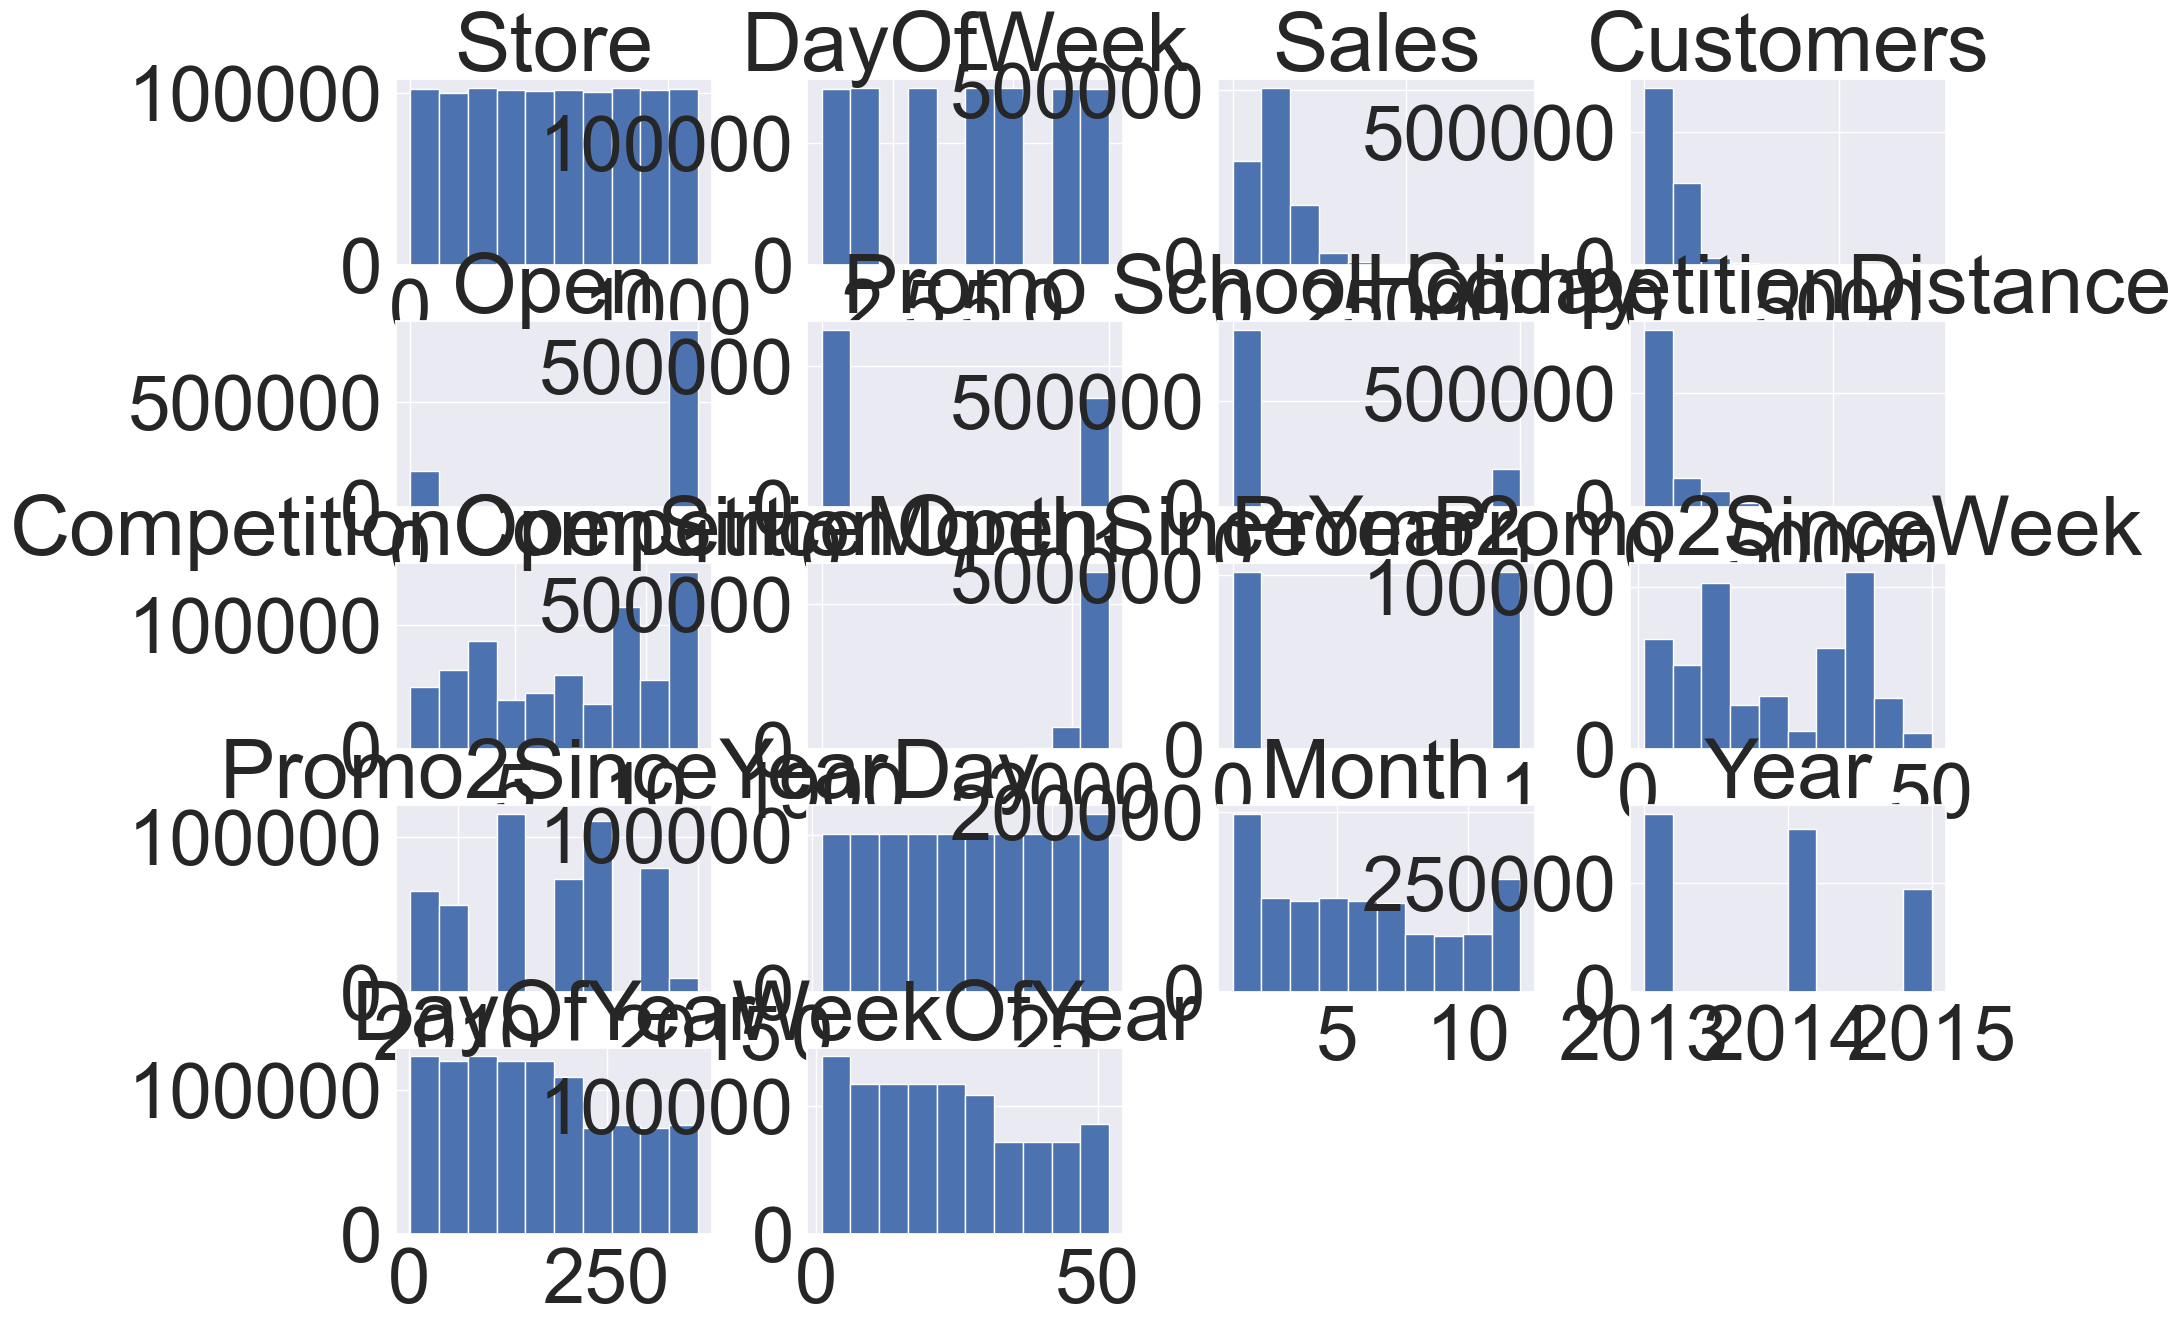

In [70]:
#Numerical Features Histograms (Train)
num_feats = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[num_feats].hist(figsize=(20,15));

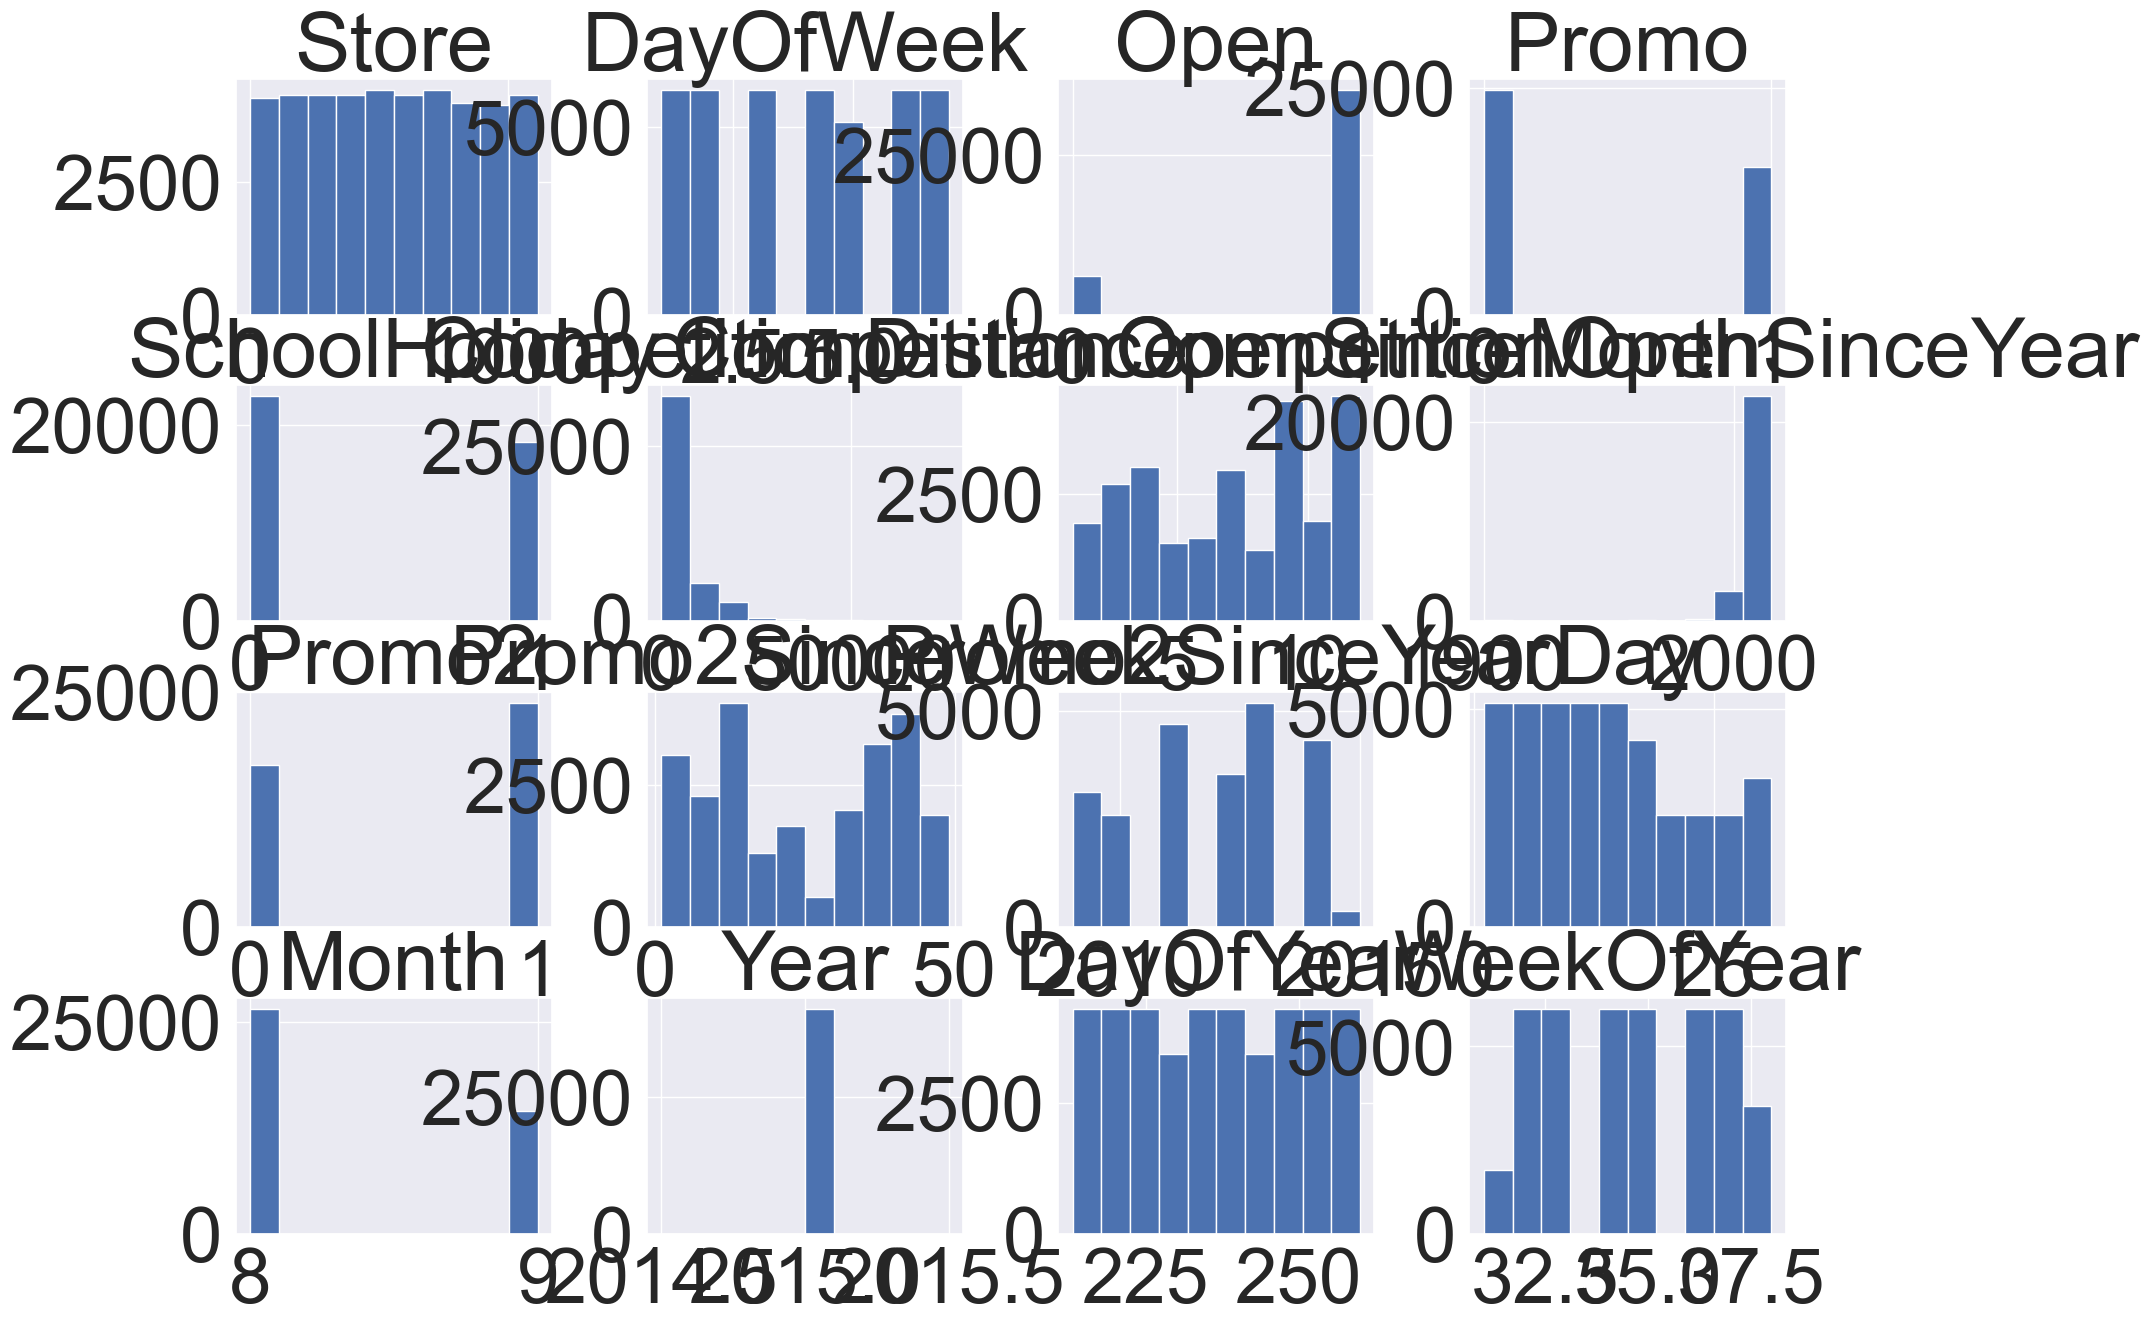

In [71]:
#Numerical Features Histograms (Test)
num_feats = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_df[num_feats].hist(figsize=(20,15));

#### We can notice several things. Firstly, the test set does not have the customers feature, so we cannot use it in prediction. But we maybe can utilize it in doing clusters for the stores.
#### Secondly, for each feature, the distribution in the training set has almost an equal corresponding one in the test set except for the feature 'SchoolHoliday' which has a lot of '1.0's values in the test set.

[]

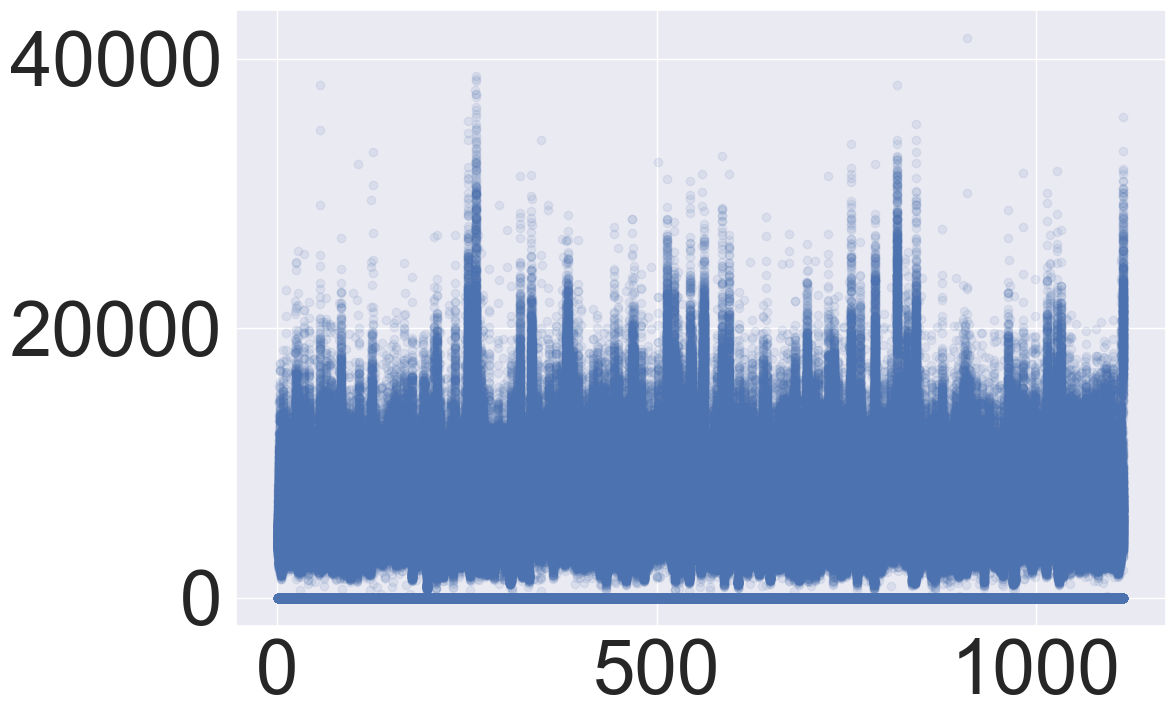

In [72]:
#Sales_Stores
plt.figure(figsize=(12, 8))
plt.scatter(train_df['Store'],train_df['Sales'], alpha=0.1);
plt.plot()

#### We can see that only several stores have sales more than 20000, and there are quite a lot of 0 sales days. This may be an indication to the days when the stores were closed. Deleting these points later would be better for forcasting well.

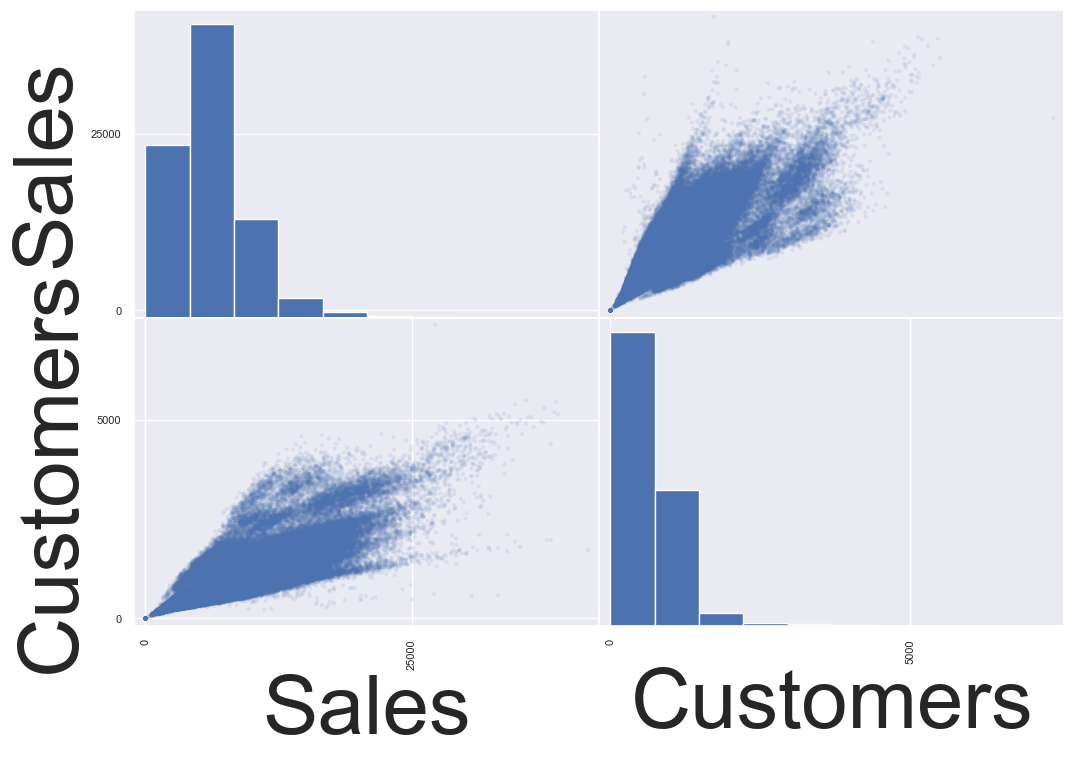

In [73]:
#Sales_Customers
attributes = ["Sales", "Customers"]
scatter_matrix(train_df[attributes], alpha=0.1);

#### Obviously, this feature is highly correlated to the target and may be a powerful predictor, but it is not in the test set, so we cannot use it except in making clusters or aggregations. 

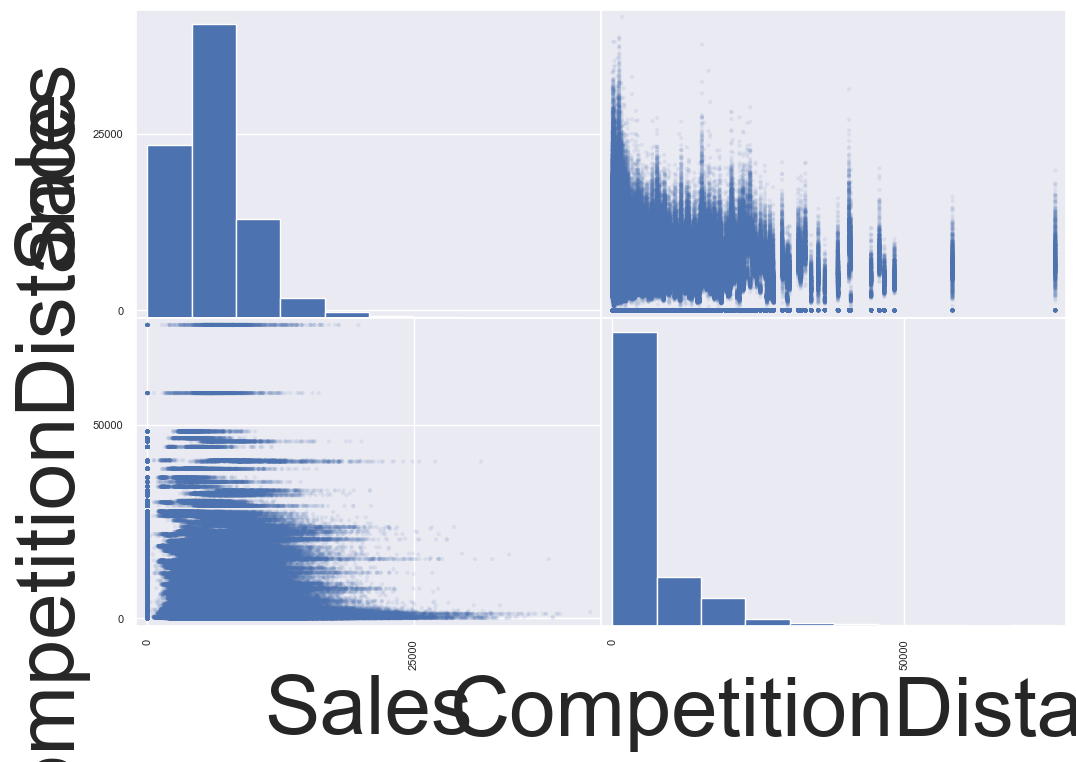

In [74]:
#Sales_CompetitionDistance
attributes = ["Sales", "CompetitionDistance"]
scatter_matrix(train_df[attributes], alpha=0.1);

#### Well, it looks like the further stores distant from each other, the lower sales they get. This maybe due to that people tend to go to places where several same stores setting next to each other in order to get best prices.
#### Also, several similar stores setting to each other may mean that their place is a big market within the city while that distant stores may mean that they are just small retailing stores.


[]

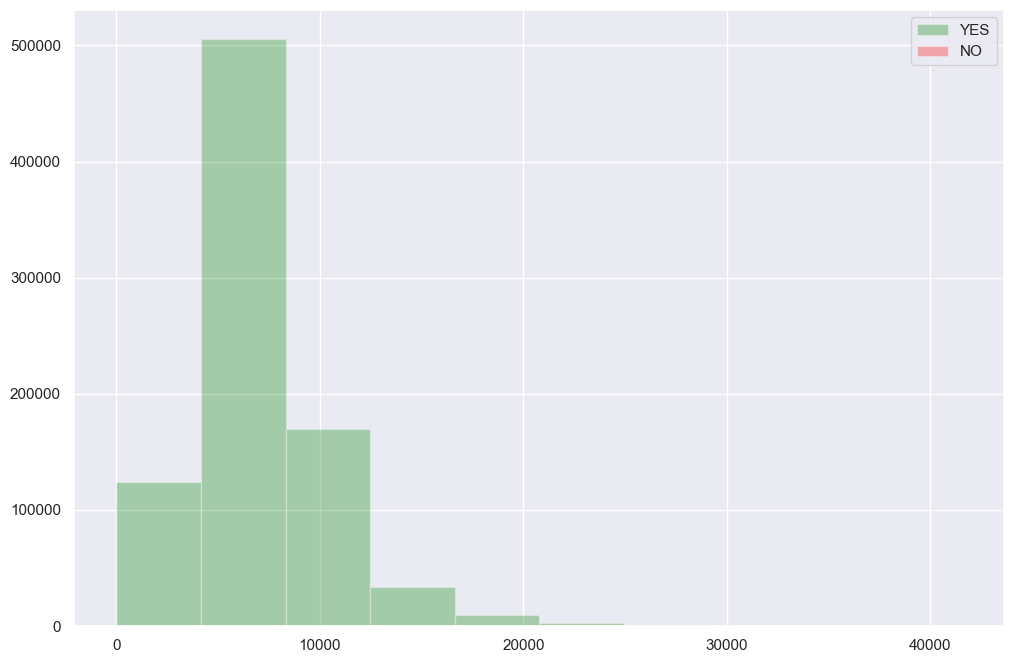

In [75]:
#Sales_Open
sns.set()
plt.hist(train_df[train_df['Open'] == 1].Sales, color='green', alpha=0.3, label = 'YES')
plt.hist(train_df[train_df['Open'] == 0].Sales, color='red', alpha=0.3, label = 'NO')
plt.legend()
plt.plot()

#### Nothing's strange. As that no red bars appeares, that does mean the store doesn't have any sales when the store is closed which is reasonable.
#### We can use this piece of information to fill some of the test set predictions manually.

[]

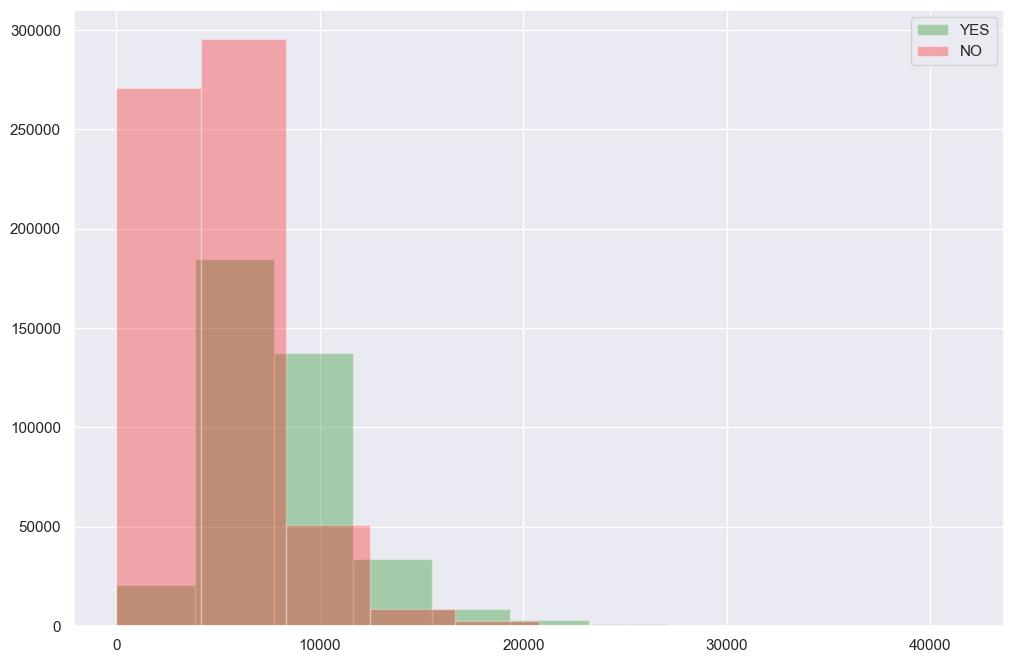

In [76]:
#Sales_Promo
sns.set()
plt.hist(train_df[train_df['Promo'] == 1].Sales, color='green', alpha=0.3, label = 'YES')
plt.hist(train_df[train_df['Promo'] == 0].Sales, color='red', alpha=0.3, label = 'NO')
plt.legend()
plt.plot()

[]

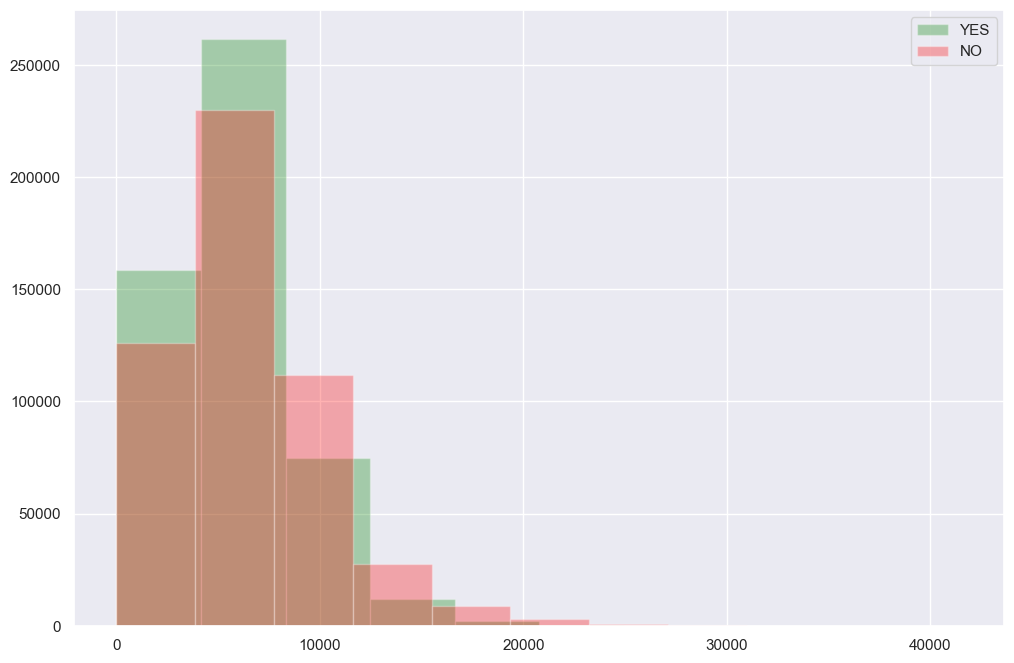

In [77]:
#Sales_Promo2
sns.set()
plt.hist(train_df[train_df['Promo2'] == 1].Sales, color='green', alpha=0.3, label = 'YES')
plt.hist(train_df[train_df['Promo2'] == 0].Sales, color='red', alpha=0.3, label = 'NO')
plt.legend()
plt.plot()

#### It looks like stores with continuing and consecutive promotions doesn't get significantly better sales than stores with indiviual promotions. In fact, it looks like the opposite is true.

[]

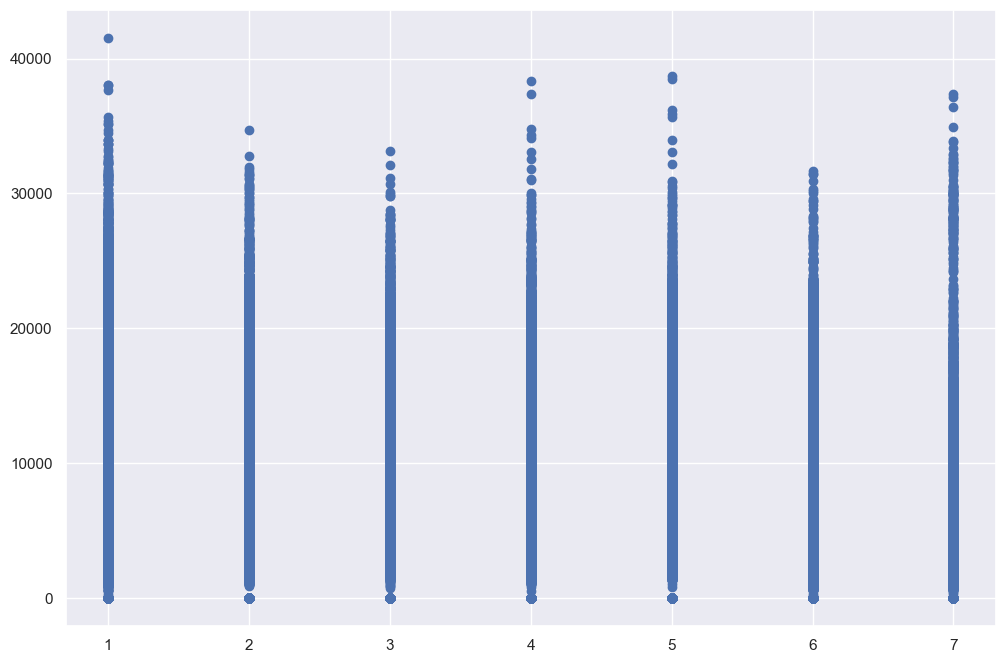

In [78]:
#Sales_DayOfWeek
plt.figure(figsize=(12, 8))
plt.scatter(train_df["DayOfWeek"],train_df["Sales"])
plt.plot()

[]

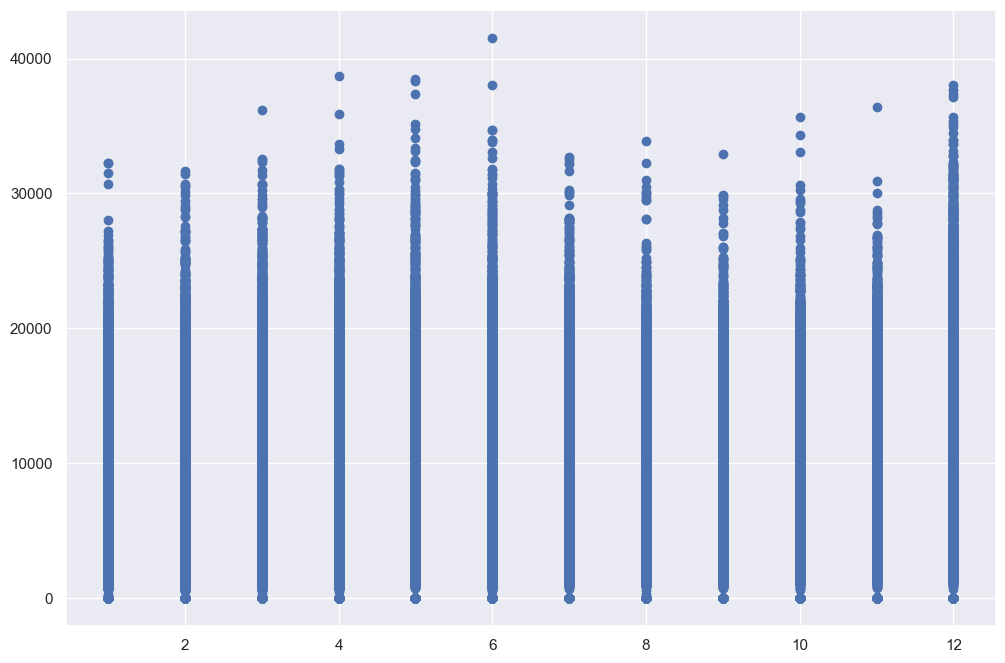

In [79]:
#Sales_Month
plt.figure(figsize=(12, 8))
plt.scatter(train_df["Month"],train_df["Sales"])
plt.plot()

#### High sales in April, May, June and December
#### Low sales in January and September

[]

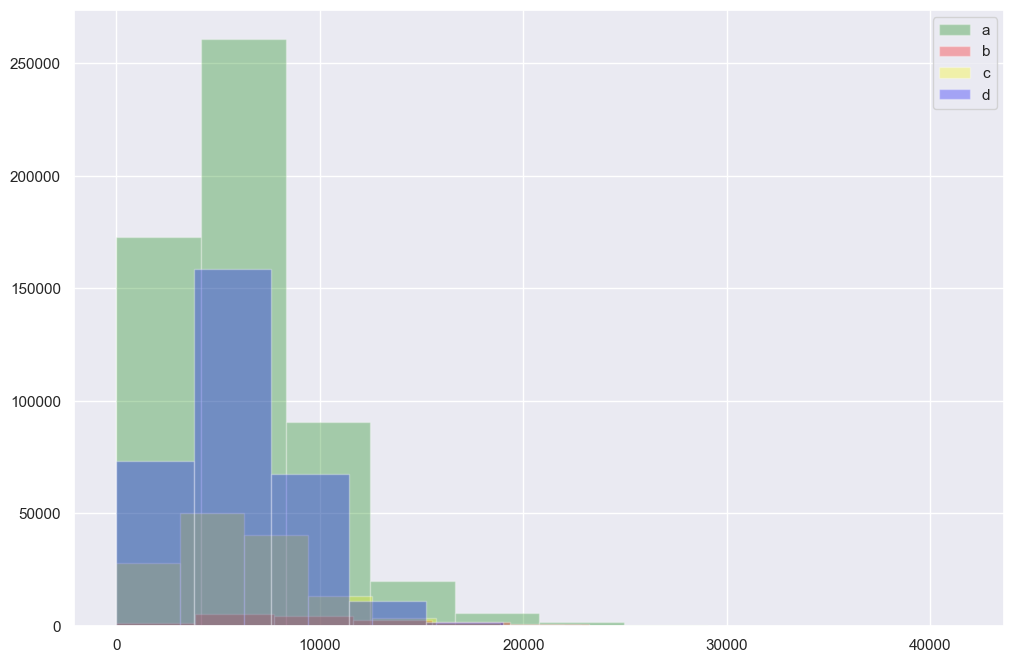

In [80]:
#Sales_StoreType
sns.set()
plt.hist(train_df[train_df['StoreType'] == 'a'].Sales, color='green', alpha=0.3, label = 'a')
plt.hist(train_df[train_df['StoreType'] == 'b'].Sales, color='red', alpha=0.3, label = 'b')
plt.hist(train_df[train_df['StoreType'] == 'c'].Sales, color='yellow', alpha=0.3, label = 'c')
plt.hist(train_df[train_df['StoreType'] == 'd'].Sales, color='blue', alpha=0.3, label = 'd')
plt.legend()
plt.plot()

#### Stores with type 'b' look like having greater mean sales than the others. 

[]

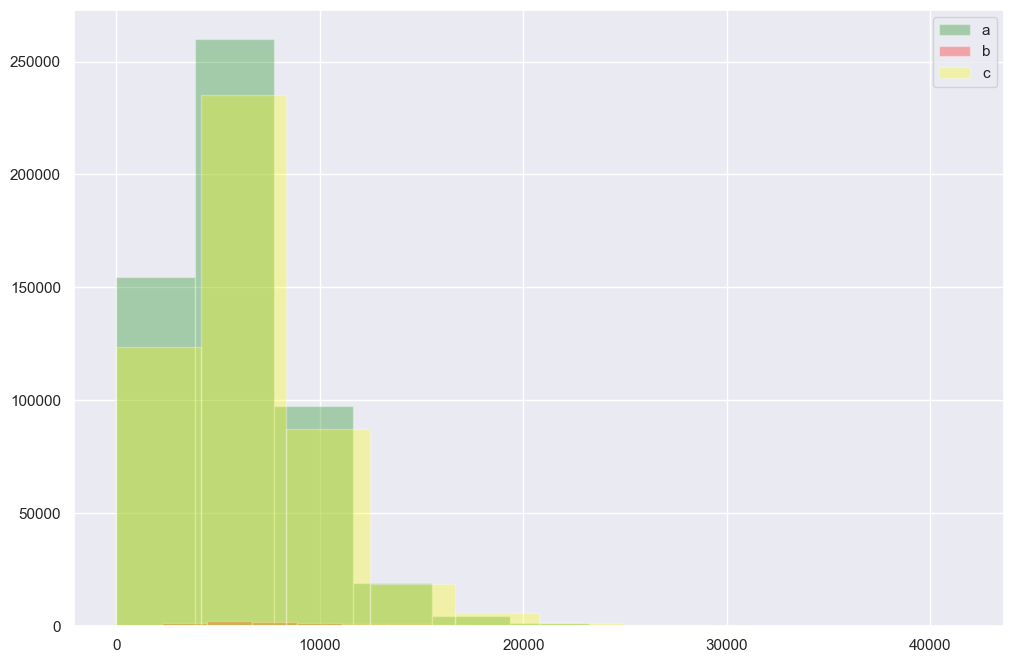

In [81]:
#Sales_Assortment
sns.set()
plt.hist(train_df[train_df['Assortment'] == 'a'].Sales, color='green', alpha=0.3, label = 'a')
plt.hist(train_df[train_df['Assortment'] == 'b'].Sales, color='red', alpha=0.3, label = 'b')
plt.hist(train_df[train_df['Assortment'] == 'c'].Sales, color='yellow', alpha=0.3, label = 'c')
plt.legend()
plt.plot()

#### Stores with Assortment 'b' look like having much less maximum sales than the others. 

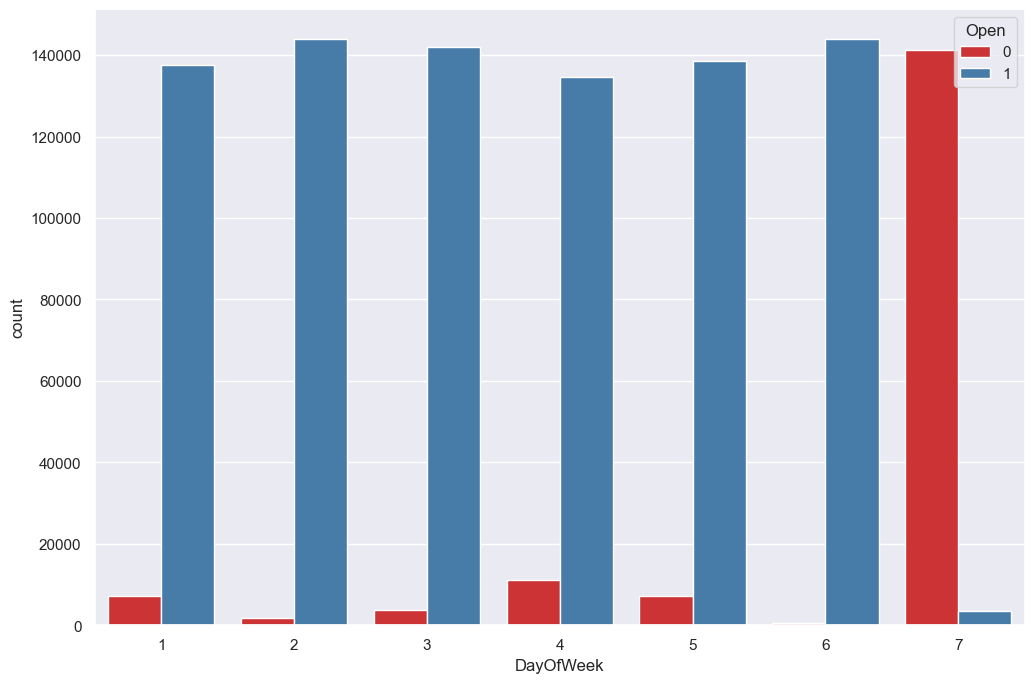

In [82]:
#Open_DayOfWeek
sns.countplot( x='DayOfWeek', data=train_df, hue="Open", palette="Set1");

#### Almost all the stores are closed at the weekend.
#### As that the data has been taken from European Countries, it is safe to say that number 7 represent Sunday.

<Axes: >

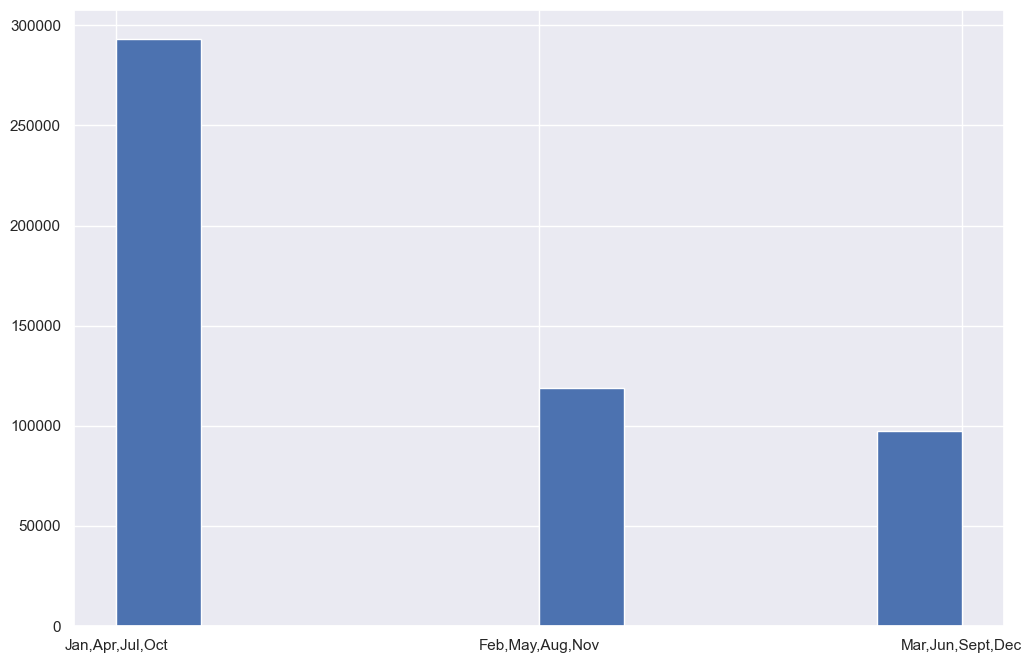

In [83]:
#PromoInterval
train_df['PromoInterval'].hist()

#### Clearly, most of the stores prefer the Jan,Apr,Jul,Oct Promo interval. 

# Feature Engineering

# Adding Aggregations

In [84]:
# Sales_per_day, Customers_per_day, avg_sales_per_customer and Sales_per_customers_per_day

# Get total sales, customers and open days per store
store_data_sales = train_df.groupby([train_df['Store']])['Sales'].sum()
store_data_customers = train_df.groupby([train_df['Store']])['Customers'].sum()
store_data_avg_sales = train_df.groupby([train_df['Store']])['Sales'].mean()
store_data_avg_customers = train_df.groupby([train_df['Store']])['Customers'].mean()
store_data_open = train_df.groupby([train_df['Store']])['Open'].count()

# Calculate sales per day, customers per day and sales per customers per day
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_avg_sales_per_customer = store_data_avg_sales / store_data_avg_customers
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

#Saving the above values in a dictionary so that they can be mapped to the dataframe.
sales_per_day_dict = dict(store_data_sales_per_day)
customers_per_day_dict = dict(store_data_customers_per_day)
avg_sales_per_customer_dict = dict(store_data_avg_sales_per_customer)
sales_per_customers_per_day_dict = dict(store_data_sales_per_customer_per_day)



train_df['SalesPerDay'] = train_df['Store'].map(sales_per_day_dict)
train_df['Customers_per_day'] = train_df['Store'].map(customers_per_day_dict)
train_df['Avg_Sales_per_Customer'] = train_df['Store'].map(avg_sales_per_customer_dict)
train_df['Sales_Per_Customers_Per_Day'] = train_df['Store'].map(sales_per_customers_per_day_dict)

test_df['Sales_per_day'] = test_df['Store'].map(sales_per_day_dict)
test_df['Customers_per_day'] = test_df['Store'].map(customers_per_day_dict)
test_df['Avg_Sales_per_Customer'] = test_df['Store'].map(avg_sales_per_customer_dict)
test_df['Sales_Per_Customers_Per_Day'] = test_df['Store'].map(sales_per_customers_per_day_dict)

## Foureier Frequnecies and Amplitudes

In [85]:
freq2_dict_no_log = dict()
freq3_dict_no_log = dict()

amp2_dict_no_log = dict()
amp3_dict_no_log = dict()

for feat_1 in ('Year','Month'):
        for i in range(min(train_df[feat_1].unique()), max(train_df[feat_1].unique()) + 1):

            a = train_df.loc[train_df[feat_1]==i]
            a_sales = a['Sales']

            Y = np.fft.fft(a_sales.values)
            Y = abs(Y)
            freq = np.fft.fftfreq(len(Y), 1)

            intercept_index = np.argmax(Y)
            Y = np.delete(Y, intercept_index)
            freq = np.delete(freq, intercept_index)

            amplitude_1_index = np.argmax(Y)
            amplitude_1 = Y[amplitude_1_index]
            Y = np.delete(Y, amplitude_1_index)
            freq_1 = freq[amplitude_1_index]
            freq = np.delete(freq, amplitude_1_index)

            amplitude_2_index = np.argmax(Y)
            amplitude_2 = Y[amplitude_2_index]
            Y = np.delete(Y, amplitude_2_index)
            freq_2 = freq[amplitude_2_index]
            freq = np.delete(freq, amplitude_2_index)

            amplitude_3_index = np.argmax(Y)
            amplitude_3 = Y[amplitude_3_index]
            Y = np.delete(Y, amplitude_3_index)
            freq_3 = freq[amplitude_3_index]
            freq = np.delete(freq, amplitude_3_index)
            

            #Freq_1 is not included because it seems as it is always 0
            a[f'Frequency_2_{feat_1}_Sales'] = freq_2
            a[f'Frequency_3_{feat_1}_Sales'] = freq_3

            a[f'Amplitude_2_{feat_1}_Sales'] = amplitude_2
            a[f'Amplitude_3_{feat_1}_Sales'] = amplitude_3


            freq2_dict_no_log[i] = freq_2
            freq3_dict_no_log[i] = freq_3

            amp2_dict_no_log[i] = amplitude_2
            amp3_dict_no_log[i] = amplitude_3


            if i == min(train_df[feat_1].unique()):
                k = a
            else:
                k = pd.concat([k,a])
        train_df = k
        test_df[f'Frequency_2_{feat_1}_Sales'] = test_df[feat_1].map(freq2_dict_no_log)
        test_df[f'Frequency_3_{feat_1}_Sales'] = test_df[feat_1].map(freq3_dict_no_log)
        test_df[f'Amplitude_2_{feat_1}_Sales'] = test_df[feat_1].map(amp2_dict_no_log)
        test_df[f'Amplitude_3_{feat_1}_Sales'] = test_df[feat_1].map(amp3_dict_no_log)
        freq2_dict_no_log = dict()
        freq3_dict_no_log = dict()
        amp2_dict_no_log = dict()
        amp3_dict_no_log = dict()


In [86]:
amp2_dict_no_log

{}

## Converting "CompetitionOpenSinceYear/Month" to Milliseconds

In [87]:
feats = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']
modes = train_df[feats].mode()

for f in feats:
        train_df[f] = train_df[f].fillna(modes[f][0])
        test_df[f] = test_df[f].fillna(modes[f][0])

#---------------------------------------------------------------------------------------------------------------- 
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

train_df['CompetitionOpenInt'] = train_df.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)
test_df['CompetitionOpenInt'] = test_df.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

## Drop 'Customers' and 'StateHoliday' Columns

In [35]:
train_df.drop('Customers',inplace = True, axis=1)  #Because it is not in the test set

In [36]:
train_df.drop('StateHoliday',inplace=True,axis=1)  #Because it reduces the performance
test_df.drop('StateHoliday',inplace=True,axis=1)

## Return to the original order

In [37]:
train_df.sort_values(["Store"], ignore_index=True, inplace=True)
test_df.sort_values(["Store"], ignore_index=True, inplace=True)
train_df.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)
test_df.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)

In [38]:
train_df

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear,SalesPerDay,Customers_per_day,Avg_Sales_per_Customer,Sales_Per_Customers_Per_Day,Frequency_2_Year_Sales,Frequency_3_Year_Sales,Amplitude_2_Year_Sales,Amplitude_3_Year_Sales,Frequency_2_Month_Sales,Frequency_3_Month_Sales,Amplitude_2_Month_Sales,Amplitude_3_Month_Sales,CompetitionOpenInt
0,1,5,5263,1,1,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN,31,7,2015,212,31,3945.705,467.646,8.437,8.437,-0.429,0.142,210709981.002,191504689.905,-0.065,-0.290,78471621.339,71724437.344,1220227200000000000
1,2,5,6064,1,1,1,a,a,570.000,11.000,2007.000,1,13.000,2010.000,"Jan,Apr,Jul,Oct",31,7,2015,212,31,4122.992,486.046,8.483,8.483,-0.429,0.142,210709981.002,191504689.905,-0.065,-0.290,78471621.339,71724437.344,1193875200000000000
2,3,5,8314,1,1,1,a,a,14130.000,12.000,2006.000,1,14.000,2011.000,"Jan,Apr,Jul,Oct",31,7,2015,212,31,5741.254,620.287,9.256,9.256,-0.429,0.142,210709981.002,191504689.905,-0.065,-0.290,78471621.339,71724437.344,1164931200000000000
3,4,5,13995,1,1,1,c,c,620.000,9.000,2009.000,0,NaN,NaN,NaN,31,7,2015,212,31,8021.770,1100.057,7.292,7.292,-0.429,0.142,210709981.002,191504689.905,-0.065,-0.290,78471621.339,71724437.344,1251763200000000000
4,5,5,4822,1,1,1,a,a,29910.000,4.000,2015.000,0,NaN,NaN,NaN,31,7,2015,212,31,3867.110,444.361,8.703,8.703,-0.429,0.142,210709981.002,191504689.905,-0.065,-0.290,78471621.339,71724437.344,1427846400000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,1,a,a,1900.000,6.000,2014.000,1,31.000,2013.000,"Jan,Apr,Jul,Oct",1,1,2013,1,1,4342.968,373.549,11.626,11.626,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1401580800000000000
1017205,1112,2,0,0,0,1,c,c,1880.000,4.000,2006.000,0,NaN,NaN,NaN,1,1,2013,1,1,8465.280,693.499,12.207,12.207,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1143849600000000000
1017206,1113,2,0,0,0,1,a,c,9260.000,9.000,2013.000,0,NaN,NaN,NaN,1,1,2013,1,1,5516.180,596.763,9.243,9.243,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1377993600000000000
1017207,1114,2,0,0,0,1,a,c,870.000,9.000,2013.000,0,NaN,NaN,NaN,1,1,2013,1,1,17200.196,2664.057,6.456,6.456,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1377993600000000000


# Data preprocessing

## Missing Values

In [39]:
#missing data percentage (Training)
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
PromoInterval,508031,49.900
Promo2SinceYear,508031,49.900
Promo2SinceWeek,508031,49.900
CompetitionDistance,2642,0.300
Store,0,0.000
Frequency_2_Year_Sales,0,0.000
Customers_per_day,0,0.000
Avg_Sales_per_Customer,0,0.000
Sales_Per_Customers_Per_Day,0,0.000
Frequency_3_Year_Sales,0,0.000


In [40]:
#missing data percentage (Testing)
total = test_df.isnull().sum().sort_values(ascending=False)
percent_1 = test_df.isnull().sum()/test_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
PromoInterval,17232,41.900
Promo2SinceYear,17232,41.900
Promo2SinceWeek,17232,41.900
CompetitionDistance,96,0.200
Open,11,0.000
Store,0,0.000
Frequency_3_Year_Sales,0,0.000
Avg_Sales_per_Customer,0,0.000
Sales_Per_Customers_Per_Day,0,0.000
Frequency_2_Year_Sales,0,0.000


In [41]:
feats = ['Promo2SinceYear','Promo2SinceWeek','CompetitionDistance', 'PromoInterval']
modes = train_df[feats].mode()

for f in feats:
        train_df[f] = train_df[f].fillna(modes[f][0])
        test_df[f] = test_df[f].fillna(modes[f][0])
for dataset in (train_df,test_df):
    dataset['Open'] = dataset['Open'].fillna(0)

# Remove Outliers

In [90]:
train_df = train_df[train_df['Sales'] < 25000]  #Drops samples which have sales more than 25000
train_df.reset_index(drop=True)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear,SalesPerDay,Customers_per_day,Avg_Sales_per_Customer,Sales_Per_Customers_Per_Day,Frequency_2_Year_Sales,Frequency_3_Year_Sales,Amplitude_2_Year_Sales,Amplitude_3_Year_Sales,Frequency_2_Month_Sales,Frequency_3_Month_Sales,Amplitude_2_Month_Sales,Amplitude_3_Month_Sales,CompetitionOpenInt
0,1,2,0,0,0,0,a,1,0,0,1270.000,9.000,2008.000,0,NaN,NaN,0,1,1,2013,1,1,3945.705,467.646,8.437,8.437,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1220227200000000000
1,1,3,5530,668,1,0,0,1,0,0,1270.000,9.000,2008.000,0,NaN,NaN,0,2,1,2013,2,1,3945.705,467.646,8.437,8.437,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1220227200000000000
2,1,4,4327,578,1,0,0,1,0,0,1270.000,9.000,2008.000,0,NaN,NaN,0,3,1,2013,3,1,3945.705,467.646,8.437,8.437,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1220227200000000000
3,1,5,4486,619,1,0,0,1,0,0,1270.000,9.000,2008.000,0,NaN,NaN,0,4,1,2013,4,1,3945.705,467.646,8.437,8.437,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1220227200000000000
4,1,6,4997,635,1,0,0,1,0,0,1270.000,9.000,2008.000,0,NaN,NaN,0,5,1,2013,5,1,3945.705,467.646,8.437,8.437,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1220227200000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016445,1115,6,6990,479,1,0,0,1,2,1,5350.000,9.000,2013.000,1,22.000,2012.000,3,27,12,2014,361,52,5225.296,358.688,14.568,14.568,-0.143,0.288,91607754.509,78311270.689,-0.065,0.290,87194679.942,67267866.970,1377993600000000000
1016446,1115,7,0,0,0,0,0,1,2,1,5350.000,9.000,2013.000,1,22.000,2012.000,3,28,12,2014,362,52,5225.296,358.688,14.568,14.568,-0.143,0.288,91607754.509,78311270.689,-0.065,0.290,87194679.942,67267866.970,1377993600000000000
1016447,1115,1,7167,509,1,0,0,1,2,1,5350.000,9.000,2013.000,1,22.000,2012.000,3,29,12,2014,363,1,5225.296,358.688,14.568,14.568,-0.143,0.288,91607754.509,78311270.689,-0.065,0.290,87194679.942,67267866.970,1377993600000000000
1016448,1115,2,7148,519,1,0,0,1,2,1,5350.000,9.000,2013.000,1,22.000,2012.000,3,30,12,2014,364,1,5225.296,358.688,14.568,14.568,-0.143,0.288,91607754.509,78311270.689,-0.065,0.290,87194679.942,67267866.970,1377993600000000000


# Encoding

## Label Encoder

In [91]:
attributes = ['StoreType','Assortment','PromoInterval']
for dataset in (train_df,test_df):
    for f in attributes:
        dataset[attributes] = dataset[attributes].apply(lambda x: pd.factorize(x)[0])

# Only Use non-zero Sales Samples For Training

In [44]:
train_df = train_df[train_df['Open'] == 1]
train_df = train_df[train_df['Sales'] > 0.0]

In [92]:
train_df[train_df['Open'] == 1]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear,SalesPerDay,Customers_per_day,Avg_Sales_per_Customer,Sales_Per_Customers_Per_Day,Frequency_2_Year_Sales,Frequency_3_Year_Sales,Amplitude_2_Year_Sales,Amplitude_3_Year_Sales,Frequency_2_Month_Sales,Frequency_3_Month_Sales,Amplitude_2_Month_Sales,Amplitude_3_Month_Sales,CompetitionOpenInt
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,0,0,1270.000,9.000,2008.000,0,NaN,NaN,0,2,1,2013,2,1,3945.705,467.646,8.437,8.437,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1220227200000000000
2013-01-03,1,4,4327,578,1,0,0,1,0,0,1270.000,9.000,2008.000,0,NaN,NaN,0,3,1,2013,3,1,3945.705,467.646,8.437,8.437,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1220227200000000000
2013-01-04,1,5,4486,619,1,0,0,1,0,0,1270.000,9.000,2008.000,0,NaN,NaN,0,4,1,2013,4,1,3945.705,467.646,8.437,8.437,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1220227200000000000
2013-01-05,1,6,4997,635,1,0,0,1,0,0,1270.000,9.000,2008.000,0,NaN,NaN,0,5,1,2013,5,1,3945.705,467.646,8.437,8.437,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1220227200000000000
2013-01-07,1,1,7176,785,1,1,0,1,0,0,1270.000,9.000,2008.000,0,NaN,NaN,0,7,1,2013,7,2,3945.705,467.646,8.437,8.437,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1220227200000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,1115,3,5603,418,1,0,0,1,2,1,5350.000,9.000,2013.000,1,22.000,2012.000,3,24,12,2014,358,52,5225.296,358.688,14.568,14.568,-0.143,0.288,91607754.509,78311270.689,-0.065,0.290,87194679.942,67267866.970,1377993600000000000
2014-12-27,1115,6,6990,479,1,0,0,1,2,1,5350.000,9.000,2013.000,1,22.000,2012.000,3,27,12,2014,361,52,5225.296,358.688,14.568,14.568,-0.143,0.288,91607754.509,78311270.689,-0.065,0.290,87194679.942,67267866.970,1377993600000000000
2014-12-29,1115,1,7167,509,1,0,0,1,2,1,5350.000,9.000,2013.000,1,22.000,2012.000,3,29,12,2014,363,1,5225.296,358.688,14.568,14.568,-0.143,0.288,91607754.509,78311270.689,-0.065,0.290,87194679.942,67267866.970,1377993600000000000


# The Correlation with The Target 

In [45]:
corr_matrix = train_df.corr()
corr_matrix["Sales"].sort_values(ascending=False)

Sales                          1.000
SalesPerDay                    0.764
Customers_per_day              0.605
Promo                          0.374
Assortment                     0.123
WeekOfYear                     0.073
Month                          0.072
Amplitude_2_Month_Sales        0.070
DayOfYear                      0.067
Amplitude_3_Month_Sales        0.051
SchoolHoliday                  0.040
Year                           0.038
StoreType                      0.037
Frequency_3_Year_Sales         0.018
CompetitionOpenSinceYear       0.010
CompetitionOpenInt             0.009
Store                          0.007
Promo2SinceWeek                0.001
Frequency_2_Year_Sales        -0.003
Avg_Sales_per_Customer        -0.007
Sales_Per_Customers_Per_Day   -0.007
Frequency_3_Month_Sales       -0.013
Frequency_2_Month_Sales       -0.014
Amplitude_2_Year_Sales        -0.031
Amplitude_3_Year_Sales        -0.032
CompetitionDistance           -0.033
CompetitionOpenSinceMonth     -0.034
D

# ML Modeling

## Initialize The Model 

In [46]:
params = {'n_estimators': 1742,
          'min_child_samples': 89,
          'n_jobs':-1,
          'learning_rate': 0.2723,
          'max_depth': -1,  
          'subsample': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 0.1,
          'reg_lambda': 1,
          'verbosity': -1}

In [47]:
#LightGBM Regressor
lgbm = LGBMRegressor(**params, random_state=42)

## Validation

In [48]:
#Sort the values to use the last days as a validation set
temp = train_df.sort_values(["Year","Month","Day"], ignore_index=True).copy()

#The same time period as the test set
train = temp[:-47000].copy()       
vali = temp[-47000:].copy()

#Return to the same order as the original dataset
train.sort_values(["Store"], ignore_index=True, inplace=True)
vali.sort_values(["Store"], ignore_index=True, inplace=True)
train.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)
vali.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)

#Get the target
y_test = vali['Sales'].copy()
vali.drop('Sales',inplace=True,axis=1)

In [93]:
train

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear,SalesPerDay,Customers_per_day,Avg_Sales_per_Customer,Sales_Per_Customers_Per_Day,Frequency_2_Year_Sales,Frequency_3_Year_Sales,Amplitude_2_Year_Sales,Amplitude_3_Year_Sales,Frequency_2_Month_Sales,Frequency_3_Month_Sales,Amplitude_2_Month_Sales,Amplitude_3_Month_Sales,CompetitionOpenInt
0,1,5,3695,1,0,0,0,0,1270.000,9.000,2008.000,0,14.000,2011.000,0,12,6,2015,163,24,3945.705,467.646,8.437,8.437,-0.429,0.142,210709981.002,191504689.905,-0.300,-0.433,69869863.541,67012473.795,1220227200000000000
1,2,5,3539,1,0,0,1,0,570.000,11.000,2007.000,1,13.000,2010.000,0,12,6,2015,163,24,4122.992,486.046,8.483,8.483,-0.429,0.142,210709981.002,191504689.905,-0.300,-0.433,69869863.541,67012473.795,1193875200000000000
2,3,5,6181,1,0,0,1,0,14130.000,12.000,2006.000,1,14.000,2011.000,0,12,6,2015,163,24,5741.254,620.287,9.256,9.256,-0.429,0.142,210709981.002,191504689.905,-0.300,-0.433,69869863.541,67012473.795,1164931200000000000
3,4,5,7889,1,0,0,0,1,620.000,9.000,2009.000,0,14.000,2011.000,0,12,6,2015,163,24,8021.770,1100.057,7.292,7.292,-0.429,0.142,210709981.002,191504689.905,-0.300,-0.433,69869863.541,67012473.795,1251763200000000000
4,5,5,4329,1,0,0,1,0,29910.000,4.000,2015.000,0,14.000,2011.000,0,12,6,2015,163,24,3867.110,444.361,8.703,8.703,-0.429,0.142,210709981.002,191504689.905,-0.300,-0.433,69869863.541,67012473.795,1427846400000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796574,682,2,3375,1,0,1,3,0,150.000,9.000,2006.000,0,14.000,2011.000,0,1,1,2013,1,1,11207.409,1758.843,6.372,6.372,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1157068800000000000
796575,733,2,10765,1,0,1,3,2,860.000,10.000,1999.000,0,14.000,2011.000,0,1,1,2013,1,1,14933.289,3403.459,4.388,4.388,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,938736000000000000
796576,769,2,5035,1,0,1,3,2,840.000,9.000,2013.000,1,48.000,2012.000,0,1,1,2013,1,1,10825.902,3081.052,3.514,3.514,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1377993600000000000
796577,948,2,4491,1,0,1,3,2,1430.000,9.000,2013.000,0,14.000,2011.000,0,1,1,2013,1,1,6833.667,1686.978,4.051,4.051,-0.285,0.142,321291277.819,309543869.378,0.290,0.419,64072091.885,50527034.741,1377993600000000000


In [49]:
#Fit the Model
lgbm.fit(train.drop('Sales',axis=1),train['Sales'])
y_pred = lgbm.predict(vali)

#Use a Correction Factor Because we transformed the target with log(x+1) then reversed it
y_pred = y_pred*0.995
score = RMSPE(y_test,y_pred)
score

0.12060523342974132

## Show the Features Importances

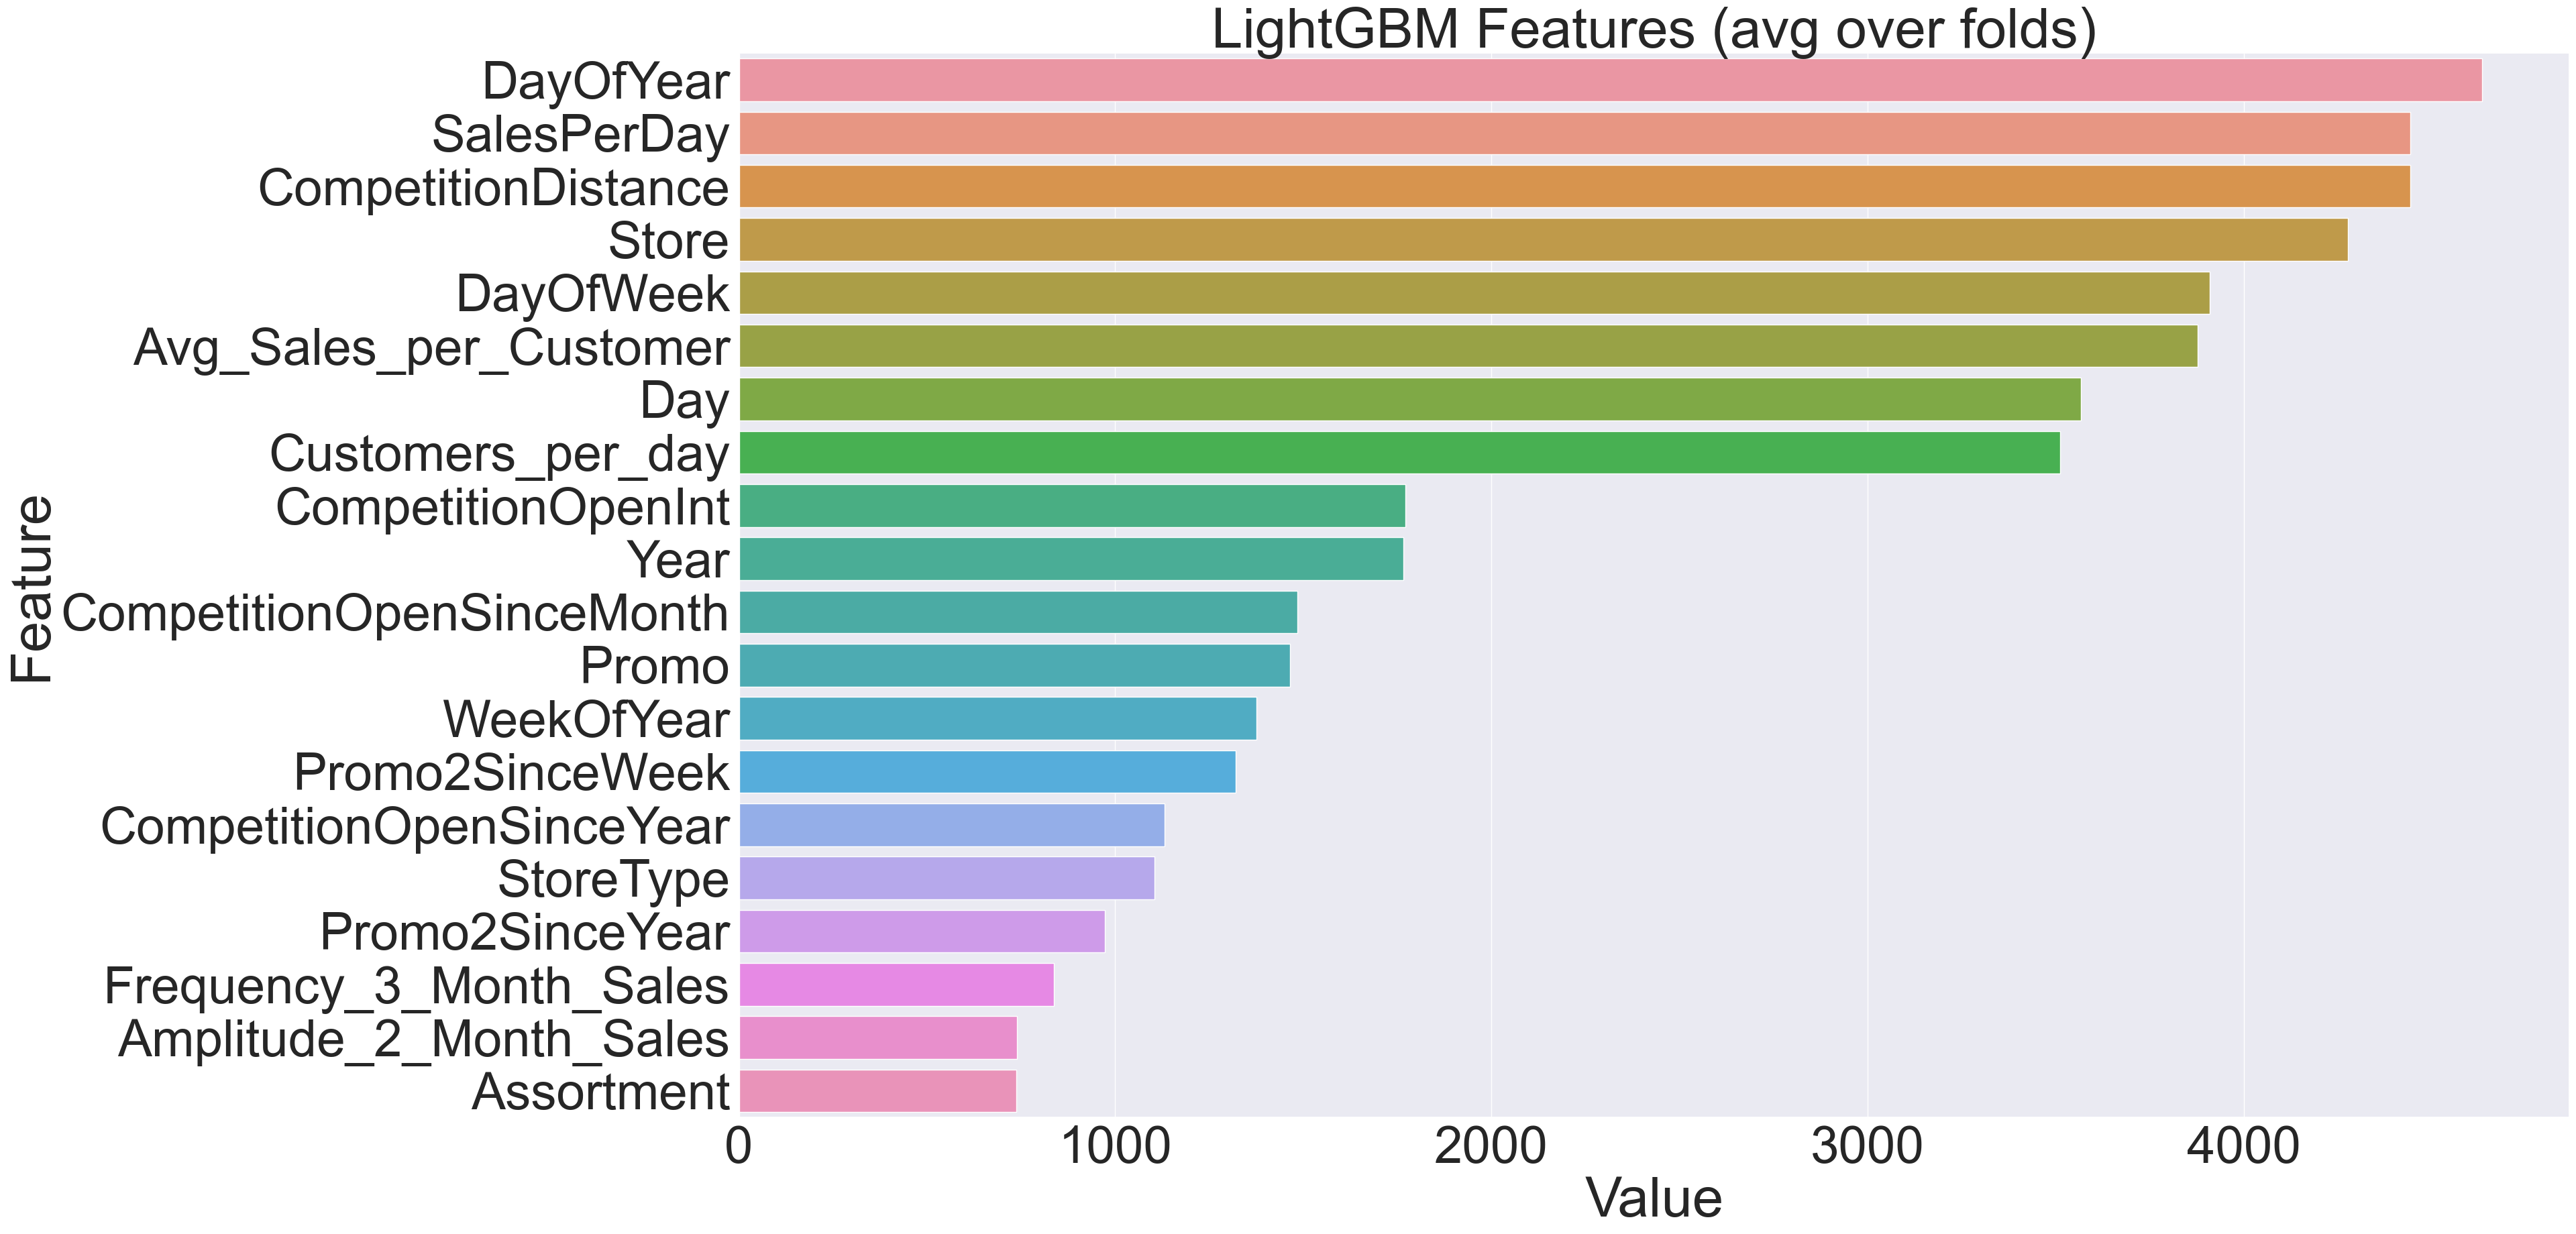

In [50]:
plotImp(lgbm,train.drop('Sales',axis=1))

# The Final Model 

## Prepare the Datasets

### We will fit the models with two datasets:

### 1- The Full Training Set 

In [ ]:
X = train_df.drop('Sales',axis=1)
y = train_df['Sales']

### 2- A Dataset Consists of Only the Data Between May and September from All The Years

In [ ]:
X_MaySept = train_df[(train_df['Month'] >= 5) & (train_df['Month'] <= 9)]
X_MaySept.reset_index(drop=True)
y_MaySept = X_MaySept['Sales']
X_MaySept = X_MaySept.drop('Sales',axis=1)

## Models: Layer 1

In [ ]:
Predictions = pd.DataFrame()

### 1- Averaging 15 Models With The Same Hyperparameters but Changing The Seed. 

### Feed Them with The Full Dataset and Get the Mean, Harmonic Mean and Geometric Mean of The Predictions.

In [ ]:
for seed in range(30,46):
    lgbm = LGBMRegressor(**params, random_state=seed)
    #Transform the target with log(x+1) to make the model able to optimize the loss function properly
    llgbm = TransformedTargetRegressor(lgbm, func = np.log1p, inverse_func = np.expm1)
    llgbm.fit(X, y)

    Predictions[f'Sales_{seed}'] = llgbm.predict(test_df)
    Predictions[f'Sales_{seed}'] = Predictions[f'Sales_{seed}'] * 0.995 #Multiply by a Correction Factor

Predictions['Mean'] = Predictions.mean(axis=1)
Predictions['HMean'] = Predictions.apply(stats.hmean, axis=1)
Predictions['GMean'] = Predictions.apply(stats.gmean, axis=1)

### 2- Averaging 15 Models With The Same Hyperparameters but Changing The Seed. 

### Feed Them with The MaySeptember Dataset and Get the Mean, Harmonic Mean and Geometric Mean of The Predictions.

In [ ]:
for seed in range(30,46):
    lgbm = LGBMRegressor(**params, random_state=seed)
    #Transform the target with log(x+1) to make the model able to optimize the loss function properly
    llgbm = TransformedTargetRegressor(lgbm, func = np.log1p, inverse_func = np.expm1)
    llgbm.fit(X_MaySept, y_MaySept)

    Predictions[f'Sales_2_{seed}'] = llgbm.predict(test_df)
    Predictions[f'Sales_2_{seed}'] = Predictions[f'Sales_2_{seed}'] * 0.995

Predictions['Mean_2'] = Predictions.mean(axis=1)
Predictions['HMean_2'] = Predictions.apply(stats.hmean, axis=1)
Predictions['GMean_2'] = Predictions.apply(stats.gmean, axis=1)

## Models: Layer 2

### Get The Harmonic Mean of The Six Predictions 

In [ ]:
FinalPred = Predictions[['Mean','HMean','GMean','Mean_2','HMean_2','GMean_2']].apply(stats.hmean,axis=1)

## Models: Make The Submission File

In [ ]:
submission = pd.DataFrame({"Id": ID ,"Sales": FinalPred.values})
submission.to_csv('FinalSubmission.csv',index=False) 

# Public Leaderboard: 0.10448
# Private Leaderboard: 0.11323